In [2]:
%load_ext autoreload
%autoreload 2
from IPython.display import SVG, display
import os
import glob
import h5py
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision import transforms
from torch.utils.data import DataLoader
from m3util.viz.style import set_style
from m3util.viz.layout import layout_fig, layout_subfigures_inches
from m3util.viz.text import labelfigs
from m3util.viz.printing import printer
printing = printer(basepath = '../../../figures/', fileformats=['png', 'svg', 'tif'], dpi=600)


from dl_utils.utils.utils import list_to_dict, sort_tasks_by_size, viz_h5_structure, find_symm_index_in_hdf5, fetch_img_metadata
from dl_utils.utils.dataset import viz_dataloader, split_train_valid, hdf5_dataset
from dl_utils.training.build_model import resnet50_, fpn_resnet50_classification, densenet161_, xcit_small
from dl_utils.analysis.case_analysis import prediction_vs_actual, most_confused_pairs, find_confused_sample, show_prediction_example
from dl_utils.analysis.attention_map import AttentionMapVisualizer
from dl_utils.analysis.attention_map import generate_attention_maps
set_style("printing")


symmetry_classes = ['p1', 'p2', 'pm', 'pg', 'cm', 'pmm', 'pmg', 'pgg', 'cmm', 'p4', 'p4m', 'p4g', 'p3', 'p3m1', 'p31m', 'p6', 'p6m']
label_converter = list_to_dict(symmetry_classes)
bs = 64
num_workers = 1

# imagenet
imagenet_ds = hdf5_dataset('../../../datasets/imagenet_v5_rot_10m_fix_vector.h5', folder='imagenet', transform=transforms.ToTensor(), classes=symmetry_classes)
train_ds, valid_ds = split_train_valid(imagenet_ds, 0.8)
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True, num_workers=num_workers)
# viz_dataloader(train_dl, label_converter=label_converter, title='imagenet - train')
valid_dl = DataLoader(valid_ds, batch_size=bs, shuffle=True, num_workers=num_workers)
# viz_dataloader(valid_dl, label_converter=label_converter, title='imagenet - valid')

# atom
atom_ds = hdf5_dataset('../../../datasets/atom_v5_rot_1m_fix_vector.h5', folder='atom', transform=transforms.ToTensor(), classes=symmetry_classes)
atom_dl = DataLoader(atom_ds, batch_size=bs, shuffle=True, num_workers=num_workers)
# viz_dataloader(atom_dl, label_converter=label_converter, title='atom - cv')

# noise
noise_ds = hdf5_dataset('../../../datasets/noise_v5_rot_1m_fix_vector.h5', folder='noise', transform=transforms.ToTensor(), classes=symmetry_classes)
noise_dl = DataLoader(noise_ds, batch_size=bs, shuffle=True, num_workers=num_workers)
# viz_dataloader(noise_dl, label_converter=label_converter, title='noise - cv')

resnet50 = resnet50_(in_channels=3, n_classes=len(symmetry_classes))
model_path = '../../../models/ResNet50/09112024-resnet50-dataset_v5_size-10m/model_epoch_20.pth'
device = torch.device('cpu')
resnet50.load_state_dict(torch.load(model_path, weights_only=True, map_location=device))
resnet50.eval()

xcit = xcit_small(in_channels=3, n_classes=len(symmetry_classes))
model_path = '../../../models/XCiT/09302024-XCiT-dataset_v5_size-10m/model_epoch_20.pth'
device = torch.device('cpu')
xcit.load_state_dict(torch.load(model_path, weights_only=True, map_location=device))
xcit.eval()

/mnt/scratch/home/yichen/anaconda3/envs/symmetry/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


printing set for seaborn


Xcit(
  (patch_embed): ConvPatchEmbed(
    (proj): Sequential(
      (0): Sequential(
        (0): Conv2d(3, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): GELU(approximate='none')
      (2): Sequential(
        (0): Conv2d(96, 192, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (3): GELU(approximate='none')
      (4): Sequential(
        (0): Conv2d(192, 384, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
  )
  (pos_embed): PositionalEncodingFourier(
    (token_projection): Conv2d(64, 384, kernel_size=(1, 1), stride=(1, 1))
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (blocks): ModuleList(
    (0-11): 12 x 

## Use confusion matrix to locate case example

In [ ]:
display(SVG(filename='../../../figures/ConfusionMatrix/Dataset 10m-ResNet50-ConfusionMatrix.svg'))
display(SVG(filename='../../../figures/ConfusionMatrix/Dataset 10m-XCiT-ConfusionMatrix.svg'))

Confused cases: p3 -> p31m, p4 -> pgg

Correction predictions (p4 -> p4, p3 -> p3) are dominant

## Attention Map: compare between models (same case)

### p4 -> p4

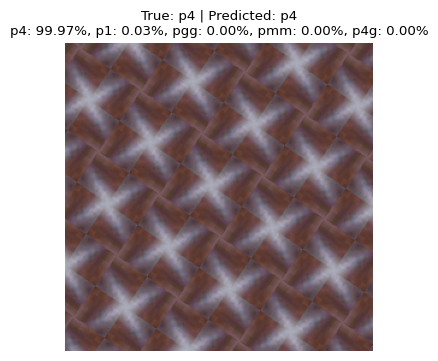

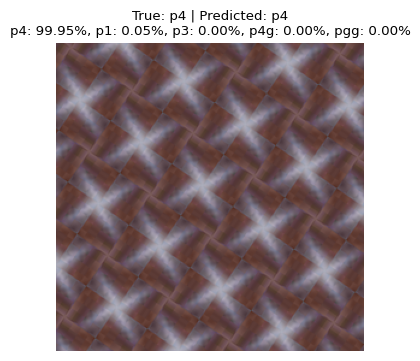

In [3]:
confusion_pair = ('p4', 'p4')
image, label_str, metadata = find_confused_sample(resnet50, valid_dl, confusion_pair, symmetry_classes, device, batch_limit=100, group=None)
# info = show_prediction_example(image, resnet50, confusion_pair, symmetry_classes, device, k=5, metadata=None)
info = show_prediction_example(image, xcit, confusion_pair, symmetry_classes, device, k=5, metadata=None)

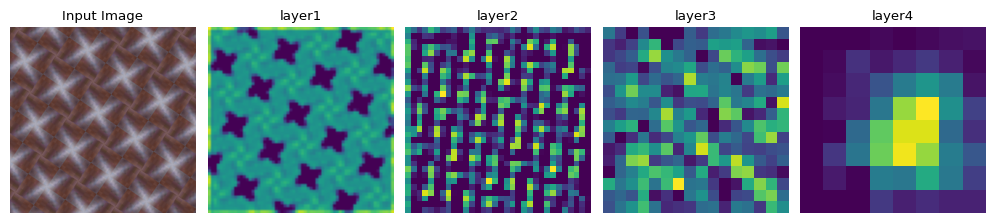

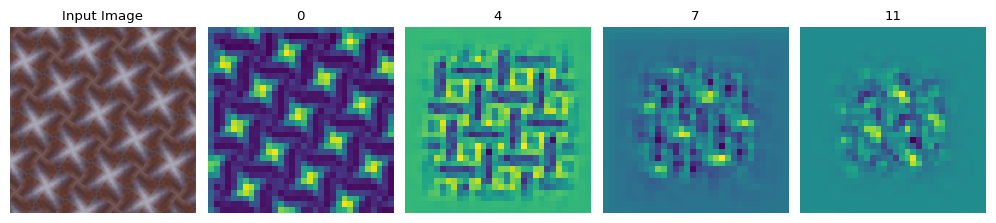

In [4]:
overlay_imgs = {'p4_p4': image}

model_type = 'ResNet50'
layers = ['layer1', 'layer2', 'layer3', 'layer4']

task_name = ''
input_image_np, overlay_attention_map_list, overlay_attention_map_list = generate_attention_maps(image, layers, task_name, resnet50, model_type, device, filename=None, viz=True)
overlay_imgs['ResNet50_layer1_p4_p4'] = overlay_attention_map_list[0]
overlay_imgs['ResNet50_layer2_p4_p4'] = overlay_attention_map_list[1]
overlay_imgs['ResNet50_layer3_p4_p4'] = overlay_attention_map_list[2]
overlay_imgs['ResNet50_layer4_p4_p4'] = overlay_attention_map_list[3]

model_type = 'XCiT'
layers = [0, 4, 7, 11]
task_name = ''
input_image_np, overlay_attention_map_list, overlay_attention_map_list = generate_attention_maps(image, layers, task_name, xcit, model_type, device, filename=None, viz=True)
overlay_imgs['XCiT_layer0_p4_p4'] = overlay_attention_map_list[0]
overlay_imgs['XCiT_layer4_p4_p4'] = overlay_attention_map_list[1]
overlay_imgs['XCiT_layer7_p4_p4'] = overlay_attention_map_list[2]
overlay_imgs['XCiT_layer11_p4_p4'] = overlay_attention_map_list[3]


../../../figures/ResNet50-XCiT-AttentionMap-p4_compare3.png
../../../figures/ResNet50-XCiT-AttentionMap-p4_compare3.svg
../../../figures/ResNet50-XCiT-AttentionMap-p4_compare3.tif


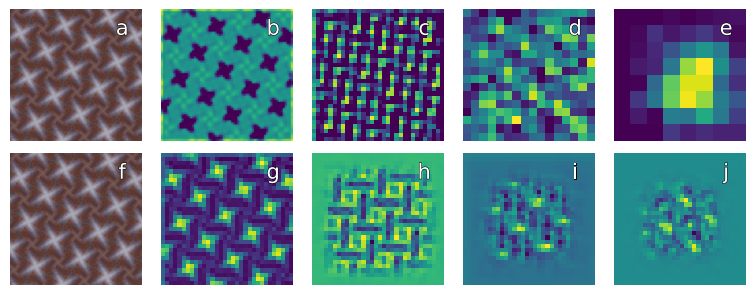

In [5]:
fig, axes = layout_fig(10, 5, figsize=(8, 3), subplot_style='subplots', layout='tight')

for i, name in enumerate([
    'p4_p4', 'ResNet50_layer1_p4_p4', 'ResNet50_layer2_p4_p4', 'ResNet50_layer3_p4_p4', 'ResNet50_layer4_p4_p4', 
    'p4_p4', 'XCiT_layer0_p4_p4', 'XCiT_layer4_p4_p4', 'XCiT_layer7_p4_p4', 'XCiT_layer11_p4_p4']):
    axes[i].imshow(overlay_imgs[name])
    axes[i].axis('off')
    labelfigs(axes[i], number=i, style='wb', loc='tr', size=15)

printing.savefig(fig, 'ResNet50-XCiT-AttentionMap-p4_compare3')
plt.show()

In [39]:
device = torch.device('cuda:1')

In [ ]:
confusion_pair = ('p4', 'pgg')
image, label_str, metadata = find_confused_sample(resnet50, valid_dl, confusion_pair, symmetry_classes, device,  batch_limit=10000, group=None)
# info = show_prediction_example(image, resnet50, confusion_pair, symmetry_classes, device, k=5, metadata=None)
info = show_prediction_example(image, xcit, confusion_pair, symmetry_classes, device, k=5, metadata=None)

In [ ]:
overlay_imgs['p4_pgg']= image

model_type = 'ResNet50' 
layers = ['layer4', 'layer3', 'layer2', 'layer1']
task_name = ''
input_image_np, overlay_attention_map_list, overlay_attention_map_list = generate_attention_maps(image, layers, task_name, resnet50, model_type, device, filename=None, viz=True)
overlay_imgs['ResNet50_layer1_p4_pgg'] = overlay_attention_map_list[-1]
overlay_imgs['ResNet50_layer4_p4_pgg'] = overlay_attention_map_list[0]

model_type = 'XCiT'
layers = [11, 7, 4, 0]
task_name = ''
input_image_np, overlay_attention_map_list, overlay_attention_map_list = generate_attention_maps(image, layers, task_name, xcit, model_type, device, filename=None, viz=True)
overlay_imgs['XCiT_layer0_p4_pgg'] = overlay_attention_map_list[-1]
overlay_imgs['XCiT_layer11_p4_pgg'] = overlay_attention_map_list[0]


In [ ]:
confusion_pair = ('p4', 'pgg')
image, label_str, metadata = find_confused_sample(resnet50, train_dl, confusion_pair, symmetry_classes, device,  batch_limit=10000, group=None)
info = show_prediction_example(image, resnet50, confusion_pair, symmetry_classes, device, k=5, metadata=None)
info = show_prediction_example(image, xcit, confusion_pair, symmetry_classes, device, k=5, metadata=None)

In [ ]:
overlay_imgs['p4_pgg']= image

model_type = 'ResNet50' 
layers = ['layer1', 'layer2', 'layer3', 'layer4']
task_name = ''
input_image_np, overlay_attention_map_list, overlay_attention_map_list = generate_attention_maps(image, layers, task_name, resnet50, model_type, device, filename=None, viz=True)
overlay_imgs['ResNet50_layer1_p4_pgg'] = overlay_attention_map_list[-1]
overlay_imgs['ResNet50_layer4_p4_pgg'] = overlay_attention_map_list[0]

model_type = 'XCiT'
layers = [0, 4, 7, 11]
task_name = ''
input_image_np, overlay_attention_map_list, overlay_attention_map_list = generate_attention_maps(image, layers, task_name, xcit, model_type, device, filename=None, viz=True)
overlay_imgs['XCiT_layer0_p4_pgg'] = overlay_attention_map_list[-1]
overlay_imgs['XCiT_layer11_p4_pgg'] = overlay_attention_map_list[0]


In [ ]:
overlay_imgs['p4_pgg']= image

model_type = 'ResNet50' 
layers = ['layer4', 'layer3', 'layer2', 'layer1']
task_name = ''
input_image_np, overlay_attention_map_list, overlay_attention_map_list = generate_attention_maps(image, layers, task_name, resnet50, model_type, device, filename=None, viz=True)
overlay_imgs['ResNet50_layer1_p4_pgg'] = overlay_attention_map_list[-1]
overlay_imgs['ResNet50_layer4_p4_pgg'] = overlay_attention_map_list[0]

model_type = 'XCiT'
layers = [11, 7, 4, 0]
task_name = ''
input_image_np, overlay_attention_map_list, overlay_attention_map_list = generate_attention_maps(image, layers, task_name, xcit, model_type, device, filename=None, viz=True)
overlay_imgs['XCiT_layer0_p4_pgg'] = overlay_attention_map_list[-1]
overlay_imgs['XCiT_layer11_p4_pgg'] = overlay_attention_map_list[0]


In [ ]:
fig, axes = layout_fig(9, 3, figsize=(8, 8), subplot_style='subplots', layout='tight')

for i, name in enumerate([
    'p4_pgg', 'p4_p4', 'p4_p4', 
    'ResNet50_layer1_p4_pgg', 'ResNet50_layer1_p4_p4', 'XCiT_layer0_p4_p4', 
    'ResNet50_layer4_p4_pgg', 'ResNet50_layer4_p4_p4', 'XCiT_layer11_p4_p4', ]):
    axes[i].imshow(overlay_imgs[name])
    axes[i].axis('off')
    labelfigs(axes[i], number=i, style='wb', loc='tr', size=15)
printing.savefig(fig, 'AttentionMap/ResNet50-XCiT-AttentionMap-all')
plt.show()

In [ ]:
subplot_width = 2
subplot_height = 2
h_gap = 0.02  # horizontal gap between columns

# Define subfigures_dict for horizontal layout
subfigures_dict = {
    "original": {"position": (0, 0, 2*subplot_width, 2 * subplot_height)},
    "ResNet50_layer1": {"position": (2*subplot_width + h_gap, subplot_height, subplot_width, subplot_height)},
    "ResNet50_layer4": {"position": (3*subplot_width + h_gap * 2, subplot_height, subplot_width, subplot_height)},
    "XCiT_layer0": {"position": (2*subplot_width + h_gap, 0, subplot_width, subplot_height)},
    "XCiT_layer11": {"position": (3*subplot_width + h_gap * 2, 0, subplot_width, subplot_height)},
}
fig, axes_dict = layout_subfigures_inches(size=(8, 4), subfigures_dict=subfigures_dict, margin_pts=10)

for i, name in enumerate(['original', 'ResNet50_layer1', 'ResNet50_layer4', 'XCiT_layer0', 'XCiT_layer11']):
    axes_dict[name].imshow(overlay_imgs[name])
    axes_dict[name].axis('off')
    labelfigs(axes_dict[name], number=i, style='wb', loc='tr', size=15)
printing.savefig(fig, 'AttentionMap/ResNet50-XCiT-AttentionMap-p4')
plt.show()

In [ ]:
subplot_width = 1.5
subplot_height = 1.5
v_gap = 0.1  # vertical gap between rows

# Define subfigures_dict
subfigures_dict = {
    "original": {"position": (0, 2 * (subplot_height + v_gap), 2 * subplot_width, 2 * subplot_height)},
    "ResNet50_layer1": {"position": (0, subplot_height + v_gap, subplot_width, subplot_height)},
    "ResNet50_layer4": {"position": (subplot_width, subplot_height + v_gap, subplot_width, subplot_height)},
    "XCiT_layer0": {"position": (0, 0, subplot_width, subplot_height)},
    "XCiT_layer11": {"position": (subplot_width, 0, subplot_width, subplot_height)},
}

# Create the figure and axes
fig, axes_dict = layout_subfigures_inches(size=(5, 8), subfigures_dict=subfigures_dict, margin_pts=10)
# axes_dict['original'].imshow(overlay_imgs['original'])
# axes_dict['ResNet50_layer1'].imshow(overlay_imgs['ResNet50_layer1'])
# axes_dict['ResNet50_layer4'].imshow(overlay_imgs['ResNet50_layer4'])
# axes_dict['XCiT_layer0'].imshow(overlay_imgs['XCiT_layer0'])
# axes_dict['XCiT_layer11'].imshow(overlay_imgs['XCiT_layer11'])

for i, name in enumerate(list(axes_dict.keys())):
    axes_dict[name].imshow(overlay_imgs[name])
    axes_dict[name].axis('off')
    labelfigs(axes_dict[name], number=i, style='wb', loc='tr', size=15)
# plt.savefig('../../../figures/AttentionMap/ResNet50-XCiT-AttentionMap-p4.png', dpi=600)
plt.show()

In [ ]:
fig, axes_dictlayout_subfigures_inches(size, subfigures_dict, margin_pts=20)

In [ ]:
fig, axes = layout_fig(4, 2, figsize=(6, 6), subplot_style='subplots', layout='tight')
for i, ax in enumerate(axes):
    ax.imshow(overlay_imgs[i])
    ax.axis('off')
    labelfigs(ax, number=i, style='wb', loc='tl', size=15)
plt.savefig('../../../figures/AttentionMap/ResNet50-XCiT-AttentionMap-p4.png', dpi=600)
plt.show()

In [ ]:
image, label_str, top_predictions, probs, metadata, info = show_prediction_example(resnet50, valid_dl, confusion_pair=('p4','p4'), classes=symmetry_classes, device=device, k=5, group='imagenet', viz=True)

In [ ]:
model_type = 'ResNet50'
layers = ['layer4', 'layer3', 'layer2', 'layer1']
task_name = ''
input_image_np, overlay_attention_map_list, overlay_attention_map_list = generate_attention_maps(image, layers, task_name, resnet50, model_type, device, filename=None, viz=True)

In [ ]:
image, label_str, top_predictions, probs, metadata, info = generate_prediction_example(xcit, valid_dl, confusion_pair=('p4','p4'), classes=symmetry_classes, device=device, k=5, group='imagenet', viz=True)

In [ ]:
info = visualize_confused_sample(image, ('p4', 'p4'), 5, probs, top_predictions, metadata)

In [ ]:
model_type = 'XCiT'
layers = [11, 7, 4, 0]
task_name = ''
input_image_np, overlay_attention_map_list, overlay_attention_map_list = generate_attention_maps(image, layers, task_name, xcit, model_type, device, filename=None, viz=True)

In [ ]:
model_type = 'XCiT'
model_path = '../../../models/XCiT/09302024-XCiT-dataset_v5_size-10m/model_epoch_20.pth'
layers = [11, 7, 4, 0]
task_name = ''
input_image_np, overlay_attention_map_list, overlay_attention_map_list = generate_attention_maps(ds_path, group, confusion_pair, layers, task_name, model_type, model_path, device, filename=None, viz=True)

### p3 -> p3

In [32]:
ds_path = f'../../../datasets/imagenet_v5_rot_10k_fix_vector_a100_0.h5'
group = 'imagenet'
confusion_pair = ('p3', 'p3')
device = torch.device('cpu')
visualizer = AttentionMapVisualizer(device=device)

In [ ]:
model_type = 'ResNet50'
model_path = '../../../models/ResNet50/09112024-resnet50-dataset_v5_size-10m/model_epoch_20.pth'
layers = ['layer4', 'layer3', 'layer2', 'layer1']
task_name = ''
input_image_np, overlay_attention_map_list, overlay_attention_map_list = generate_attention_maps(ds_path, group, confusion_pair, layers, task_name, model_type, model_path, device, filename=None, viz=True)

In [ ]:
model_type = 'XCiT'
model_path = '../../../models/XCiT/09302024-XCiT-dataset_v5_size-10m/model_epoch_20.pth'
layers = [11, 7, 4, 0]
task_name = ''
input_image_np, overlay_attention_map_list, overlay_attention_map_list = generate_attention_maps(ds_path, group, confusion_pair, layers, task_name, model_type, model_path, device, filename=None, viz=True)

## Attention Map: compare correct and wrong prediction

### p4 -> pgg

In [46]:
ds_path = f'../../../datasets/imagenet_v5_rot_10m_fix_vector.h5'
group = 'imagenet'
confusion_pair = ('p4', 'pgg')
device = torch.device('cpu')
visualizer = AttentionMapVisualizer(device=device)

In [ ]:
layers = ['layer4', 'layer3', 'layer2', 'layer1']
task_name = ''
input_image_np, overlay_attention_map_list, overlay_attention_map_list = generate_attention_maps(ds_path, group, confusion_pair, layers, task_name, model_type, model_path, device, filename=None, viz=True)

In [ ]:
model_type = 'XCiT'
model_path = '../../../models/XCiT/09302024-XCiT-dataset_v5_size-10m/model_epoch_20.pth'
layers = [11, 7, 4, 0]
task_name = ''
input_image_np, overlay_attention_map_list, overlay_attention_map_list = generate_attention_maps(ds_path, group, confusion_pair, layers, task_name, model_type, model_path, device, filename=None, viz=True)

### p3 -> p31m

In [ ]:
ds_path = f'../../../datasets/imagenet_v5_rot_10k_fix_vector_a100_0.h5'
group = 'imagenet'
confusion_pair = ('p3', 'p31m')
device = torch.device('cpu')
visualizer = AttentionMapVisualizer(device=device)

In [ ]:
model_type = 'ResNet50'
model_path = '../../../models/ResNet50/09112024-resnet50-dataset_v5_size-10m/model_epoch_20.pth'
layers = ['layer4', 'layer3', 'layer2', 'layer1']
task_name = ''
input_image_np, overlay_attention_map_list, overlay_attention_map_list = generate_attention_maps(ds_path, group, confusion_pair, layers, task_name, model_type, model_path, device, filename=None, viz=True)

In [ ]:
model_type = 'XCiT'
model_path = '../../../models/XCiT/09302024-XCiT-dataset_v5_size-10m/model_epoch_20.pth'
layers = [11, 7, 4, 0]
task_name = ''
input_image_np, overlay_attention_map_list, overlay_attention_map_list = generate_attention_maps(ds_path, group, confusion_pair, layers, task_name, model_type, model_path, device, filename=None, viz=True)

### draft

In [ ]:
model = resnet50_(in_channels=3, n_classes=17)
model.load_state_dict(torch.load('../../../models/ResNet50/09112024-resnet50-dataset_v5_size-10m/model_epoch_20.pth', weights_only=True, map_location=device))
model.eval()
layers = ['layer4', 'layer3', 'layer2', 'layer1']
model_type = 'ResNet50'

img, label, top_predictions, probs, metadata = generate_prediction_example(model, ds_path, t=confusion_pair[0], p=confusion_pair[1], classes=symmetry_classes, device=device, group=group, viz=False)
ts, va, vb, VA, VB = metadata['ts'], metadata['va'], metadata['vb'], metadata['VA'], metadata['VB']

## generate attention maps
input_tensor = transforms.ToTensor()(img).unsqueeze(0)  # Example input tensor (N, C, H, W)
attention_map_resized_list, overlay_attention_map_list = [], []
for i, layer in enumerate(layers):
    if model_type == 'ResNet50':
        input_image_np, attention_map_resized = visualizer.generate_cnn_attention_map(model, input_tensor, layer_name=layer)
    elif model_type == 'XCiT':
        input_image_np, attention_map_resized = visualizer.generate_transformer_attention_map(model, input_tensor, attention_layer_idx=layer)
    overlay_attention_map = visualizer.generate_overlay_attention_map(input_image_np, attention_map_resized, alpha=0.4)
    attention_map_resized_list.append(attention_map_resized)
    overlay_attention_map_list.append(overlay_attention_map)
    
num_figs = len(layers)+1
fig, axes = layout_fig(num_figs, num_figs, figsize=(2*num_figs, num_figs*2.8), subplot_style='subplots', layout='tight')
axes[0].imshow(input_image_np)
axes[0].axis('off')
axes[0].set_title(f'Input Image - True: {label}, Pred: {top_predictions[0]}')
for i, ax in enumerate(axes[1:]):
    ax.imshow(overlay_attention_map_list[i])
    ax.axis('off')
    ax.set_title(f'{layers[i]}')
plt.show()


In [ ]:
device = torch.device('cpu')
model = xcit_small(in_channels=3, n_classes=17)
model.load_state_dict(torch.load('../../../models/XCiT/09302024-XCiT-dataset_v5_size-10m/model_epoch_20.pth', weights_only=True, map_location=device))
model.eval()
layers = [11, 7, 4, 0]
model_type = 'XCiT'

img, label, top_predictions, probs, metadata = generate_prediction_example(model, ds_path, t=confusion_pair[0], p=confusion_pair[1], classes=symmetry_classes, device=device, group=group, viz=False)
ts, va, vb, VA, VB = metadata['ts'], metadata['va'], metadata['vb'], metadata['VA'], metadata['VB']

## generate attention maps
visualizer = AttentionMapVisualizer(device=device)
input_tensor = transforms.ToTensor()(img).unsqueeze(0)  # Example input tensor (N, C, H, W)
attention_map_resized_list, overlay_attention_map_list = [], []
for i, layer in enumerate(layers):
    if model_type == 'ResNet50':
        input_image_np, attention_map_resized = visualizer.generate_cnn_attention_map(model, input_tensor, layer_name=layer)
    elif model_type == 'XCiT':
        input_image_np, attention_map_resized = visualizer.generate_transformer_attention_map(model, input_tensor, attention_layer_idx=layer)
    overlay_attention_map = visualizer.generate_overlay_attention_map(input_image_np, attention_map_resized, alpha=0.4)
    attention_map_resized_list.append(attention_map_resized)
    overlay_attention_map_list.append(overlay_attention_map)
    
num_figs = len(layers)+1
fig, axes = layout_fig(num_figs, num_figs, figsize=(2*num_figs, num_figs*2.8), subplot_style='subplots', layout='tight')
axes[0].imshow(input_image_np)
axes[0].axis('off')
axes[0].set_title(f'Input Image - True: {label}, Pred: {top_predictions[0]}')
for i, ax in enumerate(axes[1:]):
    ax.imshow(overlay_attention_map_list[i])
    ax.axis('off')
    ax.set_title(f'{layers[i]}')
plt.show()

In [ ]:
## generate attention maps

visualizer = AttentionMapVisualizer(device=device)
input_tensor = transforms.ToTensor()(img).unsqueeze(0)  # Example input tensor (N, C, H, W)
# stats = f"True: {label} | Predicted: " + f", ".join(f"{pred}({prob.item() * 100:.2f}%)" for prob, pred in zip(probs, top_predictions))

layers = [11, 8, 5, 3, 0]
attention_map_resized_list, overlay_attention_map_list = [], []
fig, axes = layout_fig(len(layers)*3, 3, figsize=(8, len(layers)*2.8), subplot_style='subplots', layout='tight')
for i, layer in enumerate(layers):
    if model_type == 'ResNet50':
        input_image_np, attention_map_resized = visualizer.generate_cnn_attention_map(model, input_tensor, layer_name=layer)
    elif model_type == 'XCiT':
        input_image_np, attention_map_resized = visualizer.generate_transformer_attention_map(model, input_tensor, attention_layer_idx=layer)
        
    overlay_attention_map = visualizer.visualize_attention_map(input_image_np, attention_map_resized, keyword=layer, fig=fig, axes=axes[i*3:i*3+3])
    attention_map_resized_list.append(attention_map_resized)
    overlay_attention_map_list.append(overlay_attention_map)
    
# plt.suptitle(f"{task_name}: {stats}", fontsize=10)
plt.show()

In [6]:
visualizer = AttentionMapVisualizer()

In [ ]:
model = resnet50_(in_channels=3, n_classes=len(symmetry_classes))
model.load_state_dict(torch.load('../../models/ResNet50/09112024-resnet50-dataset_v5_size-10m/model_epoch_20.pth', weights_only=True))
model.eval()

input_tensor = train_ds[0][0].unsqueeze(0)  # Example input tensor (N, C, H, W)
for i in ['layer4', 'layer3', 'layer2', 'layer1']:
    input_image_np, attention_map_resized = visualizer.generate_cnn_attention_map(model, input_tensor, layer_name=i)
    visualizer.visualize_attention_map(input_image_np, attention_map_resized, title=f"ResNet50 - {i}")

In [ ]:
model = xcit_small(in_channels=3, n_classes=len(symmetry_classes))
model.load_state_dict(torch.load('../../models/XCiT/09302024-XCiT-dataset_v5_size-10m/model_epoch_20.pth', weights_only=True))
model.eval()
input_tensor = train_ds[1][0].unsqueeze(0)  # Example input tensor (N, C, H, W)
for i in [11, 8, 5, 3, 0]:
    input_image_np, attention_map_resized = visualizer.generate_transformer_attention_map(model, input_tensor, attention_layer_idx=i)
    visualizer.visualize_attention_map(input_image_np, attention_map_resized, title=f"XCiT - attention_layer_idx {i+1}/12")

In [ ]:
model = xcit_small(in_channels=3, n_classes=len(symmetry_classes))
model.load_state_dict(torch.load('../../../models/XCiT/09302024-XCiT-dataset_v5_size-10m/model_epoch_20.pth', weights_only=True))
model.eval()
input_tensor = train_ds[2][0].unsqueeze(0)  # Example input tensor (N, C, H, W)

for i in [11, 8, 5, 3, 0]:
    attention_map_resized = visualizer.generate_transformer_attention_map(model, input_tensor, attention_layer_idx=i)
    visualizer.visualize_attention_map(input_tensor, attention_map_resized)

In [ ]:
attention_map_resized.shape

In [ ]:
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from torchcam.methods import GradCAM, SmoothGradCAMpp
from torchcam.utils import overlay_mask
from PIL import Image

In [ ]:
from PIL import Image
from torchcam.methods import GradCAM
def generate_attention_map(
    model, input_tensor, layer_name="layer4", alpha=0.5, colormap="viridis"
):
    """
    Generates and visualizes an attention map for a given model and input tensor using Grad-CAM.

    Args:
        model (torch.nn.Module): The pre-trained model (ResNet50 or similar).
        input_tensor (torch.Tensor): The input tensor with shape (1, C, H, W).
        layer_name (str): The name of the target layer for Grad-CAM (default: "layer4").
        alpha (float): Transparency for the overlay (default: 0.5).
        colormap (str): Colormap to use for the attention map (default: "viridis").

    Returns:
        None: Displays the original image and its attention map.
    """

    # Ensure the model is in evaluation mode
    model.eval()

    # Initialize Grad-CAM extractor for the specified layer
    cam_extractor = GradCAM(model, layer_name)

    # Forward pass with gradients enabled
    input_tensor.requires_grad = True  # Ensure gradients are tracked for the input
    output = model(input_tensor)

    # Extract the class index with the highest prediction score
    pred_class = output.squeeze(0).argmax().item()

    # Compute the attention map for the predicted class
    attention_map = cam_extractor(pred_class, output)

    # Release Grad-CAM hooks
    cam_extractor.remove_hooks()

    # Convert the input tensor to a PIL image
    input_image = Image.fromarray(
        (input_tensor.squeeze(0).permute(1, 2, 0).detach().numpy() * 255).astype("uint8")
    )
    print(input_image.size)
    
    # Process the attention map for visualization
    attention_map_np = attention_map[0].squeeze().cpu().numpy()  # Ensure it's on the CPU
    attention_map_resized = np.array(
        Image.fromarray(attention_map_np).resize(input_image.size, Image.BILINEAR)
    )
    attention_map_resized = (attention_map_resized - attention_map_resized.min()) / (
        attention_map_resized.max() - attention_map_resized.min()
    )
    print(attention_map_resized.shape)
    
    # Apply the colormap
    cmap = plt.get_cmap(colormap)
    colored_attention_map = cmap(attention_map_resized)[:, :, :3]  # Keep RGB only

    # Create overlay manually
    input_image_np = np.asarray(input_image)
    overlay = (alpha * input_image_np + (1 - alpha) * (colored_attention_map * 255)).astype("uint8")

    # Plot the results with a colorbar
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].imshow(input_image)
    ax[0].set_title("Original Image")
    ax[0].axis("off")

    im = ax[1].imshow(attention_map_resized, cmap=colormap)
    ax[1].set_title("Attention Map (Colormap)")
    ax[1].axis("off")
    fig.colorbar(im, ax=ax[1], fraction=0.046, pad=0.04)

    ax[2].imshow(overlay)
    ax[2].set_title("Overlayed Attention Map")
    ax[2].axis("off")

    plt.tight_layout()
    plt.show()

model = resnet50_(in_channels=3, n_classes=len(symmetry_classes))
model.load_state_dict(torch.load('../../../models/ResNet50/09112024-resnet50-dataset_v5_size-10m/model_epoch_20.pth', weights_only=True))

# Load an example image from your dataset
input_tensor = train_ds[0][0].unsqueeze(0)  # Example input tensor (N, C, H, W)

# Generate the attention map with a colormap
generate_attention_map(model, input_tensor, layer_name="layer4", alpha=0.5, colormap="viridis")

In [ ]:
def generate_transformer_attention_map(
    model, input_tensor, attention_layer_idx=-1, alpha=0.5, colormap="viridis"
):
    """
    Generates and visualizes attention maps for a transformer model using token-feature embeddings.

    Args:
        model (torch.nn.Module): The transformer model (e.g., XCiT).
        input_tensor (torch.Tensor): The input tensor with shape (1, C, H, W).
        attention_layer_idx (int): Index of the attention layer to visualize (-1 for the last layer).
        alpha (float): Transparency for the overlay (default: 0.5).
        colormap (str): Colormap to use for the attention map (default: "viridis").

    Returns:
        None: Displays the input image and its attention map.
    """
    import matplotlib.pyplot as plt
    import numpy as np
    from PIL import Image

    # Ensure the model is in evaluation mode
    model.eval()

    # Hook to capture attention weights
    attention_weights = []

    def hook_fn(module, input, output):
        attention_weights.append(output)

    # Register the hook for the specified attention layer
    layer_to_hook = model.blocks[attention_layer_idx].attn
    hook_handle = layer_to_hook.register_forward_hook(hook_fn)

    # Forward pass through the model
    with torch.no_grad():
        model(input_tensor)

    # Remove the hook after the forward pass
    hook_handle.remove()

    # Check the captured attention weights
    if len(attention_weights) == 0:
        raise ValueError("No attention weights were captured. Check the attention layer indexing.")

    attn_weights = attention_weights[0]  # Shape: (1, 1024, 384)

    # Reshape the attention weights into a spatial map
    tokens = attn_weights.shape[1]  # 1024 tokens
    grid_size = int(tokens**0.5)  # Assume square grid (e.g., 32x32 if 1024 tokens)
    if tokens != grid_size**2:
        raise ValueError(
            f"Number of tokens ({tokens}) cannot be reshaped into a square grid. "
            "Check the model's configuration."
        )

    # Aggregate attention across the embedding dimension (e.g., mean or sum)
    attn_map = attn_weights.mean(dim=-1).squeeze(0).cpu().numpy()  # Shape: (1024,)
    attn_map = attn_map.reshape(grid_size, grid_size)  # Reshape to (Grid, Grid)

    # Normalize the attention map
    attn_map = (attn_map - attn_map.min()) / (attn_map.max() - attn_map.min())

    # Resize the attention map to match the input image resolution
    input_image_np = np.asarray(
        (input_tensor.squeeze(0).permute(1, 2, 0).cpu().numpy() * 255).astype("uint8")
    )
    attention_map_resized = np.array(
        Image.fromarray((attn_map * 255).astype("uint8")).resize(
            input_image_np.shape[:2][::-1], Image.BILINEAR
        )
    ) / 255.0

    # Apply the colormap
    cmap = plt.get_cmap(colormap)
    colored_attention_map = cmap(attention_map_resized)[:, :, :3]  # Keep RGB only

    # Create overlay manually
    colored_attention_map_np = (colored_attention_map * 255).astype("uint8")
    overlay = (
        alpha * input_image_np + (1 - alpha) * colored_attention_map_np
    ).astype("uint8")

    # Plot the results with a colorbar
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].imshow(input_image_np)
    ax[0].set_title("Original Image")
    ax[0].axis("off")

    im = ax[1].imshow(attn_map, cmap=colormap)
    ax[1].set_title("Attention Map (Colormap)")
    ax[1].axis("off")
    fig.colorbar(im, ax=ax[1], fraction=0.046, pad=0.04)

    ax[2].imshow(overlay)
    ax[2].set_title("Overlayed Attention Map")
    ax[2].axis("off")

    plt.tight_layout()
    plt.show()
    
model = xcit_small(in_channels=3, n_classes=len(symmetry_classes))
model.load_state_dict(torch.load('../../../models/XCiT/09302024-XCiT-dataset_v5_size-10m/model_epoch_20.pth', weights_only=True))
model.eval

# Load an input image and preprocess
input_tensor = train_ds[0][0].unsqueeze(0)  # Example input tensor (N, C, H, W)

# Generate attention map for the last attention block
generate_transformer_attention_map(model, input_tensor, attention_layer_idx=-1, colormap="viridis")

In [19]:
import torch
from torchcam.methods import GradCAM
from torchcam.utils import overlay_mask
from PIL import Image
import matplotlib.pyplot as plt

# Assuming your custom ResNet50 model is already defined and loaded
# model = ResNet(...)

# Set the model to evaluation mode
model.eval()

# Load an image from your dataset
input_tensor = train_ds[0][0].unsqueeze(0)  # Add batch dimension # shape is N, C, H, W

# Initialize Grad-CAM extractor for the last convolutional layer (layer4)
cam_extractor = GradCAM(model, "layer4")

# Forward pass (ensure gradients are enabled)
output = model(input_tensor)

# Extract the attention map for the predicted class
pred_class = output.squeeze(0).argmax().item()
attention_map = cam_extractor(pred_class, output)

# Release the CAM extractor
cam_extractor.remove_hooks()

In [ ]:
input_tensor.shape, attention_map[0].shape

In [37]:
# Convert the input tensor to a PIL image for visualization
input_image = Image.fromarray((input_tensor.squeeze(0).permute(1, 2, 0).numpy() * 255).astype('uint8'))

# Convert the attention map to a PIL image
attention_map_np = attention_map[0].squeeze().numpy()  # Shape: (H', W')
attention_map_resized = np.array(Image.fromarray(attention_map_np).resize(input_image.size, Image.BILINEAR))  # Resize to (H, W)

# Normalize the attention map to [0, 1] for visualization
attention_map_resized = (attention_map_resized - attention_map_resized.min()) / (attention_map_resized.max() - attention_map_resized.min())

# Convert the resized attention map to a PIL image
attention_map_pil = Image.fromarray((attention_map_resized * 255).astype('uint8'))

# Overlay the attention map on the input image
overlay = overlay_mask(input_image, attention_map_pil, alpha=0.5)

In [ ]:
# Plot the results
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(input_image)
ax[0].set_title("Original Image")
ax[0].axis("off")

im1 = ax[1].imshow(overlay)
ax[1].set_title("ResNet50 Attention Map")
ax[1].axis("off")
fig.colorbar(im1, ax=ax[1], fraction=0.046, pad=0.04)

plt.show()